# Analyze models
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

from scipy.signal import savgol_filter

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp20C_126'#'exp20C_126_all7'#'exp20C_126'#'exp20C_126'#'exp15C_370_uniform' #'exp15C_126_uniform'#'exp20C_126'
#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
# display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Get seed to show in plot
You need to first run compare_random_seeds.ipynb to ensure the data/stats on your experiments were saved in the df_random_seed.pickle file.

In [4]:
df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_val'].idxmin()]["seed"]
PLOT_SEED = 2247
print(PLOT_SEED)
display(df)

2247


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,best_2021_mu,best_2021_sigma,giss_2021_mu,giss_2021_sigma
30,exp20C_126,1257,"[25, 25]",10.0,7.268264,7.518819,3.585745,3.717865,0.021563,0.035914,0.025022,34.198341,10.450936,35.966370,11.021051
31,exp20C_126,5322,"[25, 25]",10.0,7.731330,8.072323,3.707627,3.815524,0.025088,0.039829,0.028687,33.663563,12.379835,34.287029,13.294614
32,exp20C_126,2247,"[25, 25]",10.0,6.565131,7.224609,3.498148,3.497752,0.015088,0.020070,0.012474,33.390503,10.748096,35.306496,10.607298
33,exp20C_126,5757,"[25, 25]",10.0,7.969829,7.084301,3.678048,3.577131,0.026044,0.035460,0.021482,34.418289,11.227134,34.708149,11.811220
34,exp20C_126,1170,"[25, 25]",10.0,7.077800,7.373015,3.607664,3.531736,0.014664,0.021563,0.015591,29.768965,12.270633,32.114433,12.755111
35,exp20C_126,9156,"[25, 25]",10.0,7.181680,8.342739,3.585295,3.787789,0.014959,0.044859,0.019886,35.741478,11.480177,35.210289,12.899955
36,exp20C_126,6613,"[25, 25]",10.0,7.435185,7.875543,3.599294,3.771148,0.017344,0.046154,0.021274,36.632370,10.365854,37.786198,10.457793
37,exp20C_126,9983,"[25, 25]",10.0,8.075982,7.036954,3.683837,3.562861,0.021138,0.017594,0.015480,36.292522,11.788376,36.213139,13.070307
38,exp20C_126,4348,"[25, 25]",10.0,7.632088,7.128813,3.725252,3.623173,0.028980,0.022242,0.025273,35.712990,11.629762,37.019508,12.102551
39,exp20C_126,5869,"[25, 25]",10.0,8.166584,8.121635,3.793880,3.779634,0.029995,0.041827,0.031632,37.790192,13.023808,38.290176,14.635632


## Plotting Functions

In [5]:
FS = 10

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [6]:
model_name_plot = EXP_NAME + '_' + str(PLOT_SEED)

In [7]:
imp.reload(file_methods)
imp.reload(data_processing)

rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get model name
model_name = file_methods.get_model_name(settings)

# load the model
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

settings_new = settings
settings_new["gcmsub"] = "OOS"
settings_new["n_train_val_test"] = (0, 0, 5)
# get the data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)   

       

2022-04-12 14:29:54.949984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[] [] [2 0 4 1 3]
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2048, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2071, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2075, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_IPSL-CM6A-LR_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2033, TARGET_TEMP = 2.0
---------------------------
data_train.shape = (0, 131, 72, 144)
data_val.shape = (0, 131, 72, 144)
data_test.shape = (35, 131, 72, 144)
(0, 10368) (0,) (0,)
(0, 10368) (0,) (0,)
(4585, 10368) (4585,) (4

tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2100, TARGET_TEMP = 2.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc


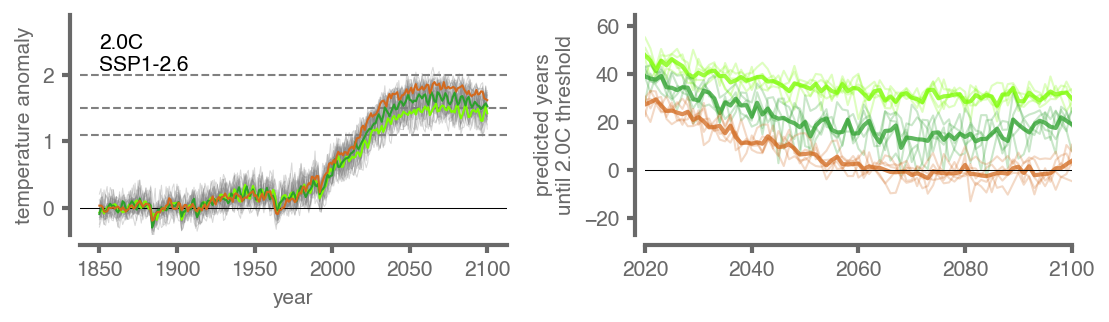

In [17]:
filenames = file_methods.get_cmip_filenames(settings_new, verbose=0)
N_GCMS = len(filenames)
N_MEMBERS = settings["n_train_val_test"][-1]
target_list = []

# loop through the models and plot
clr = ('lawngreen','tab:green','chocolate')
fig,axs = plt.subplots(1,2,figsize=(3*2.5,2.25))


#---------------------------------------------
plt.subplot(1,2,1)
for imodel in np.arange(0,3):
    f = filenames[imodel]
    print(f)
    da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
    f_labels, f_years, f_target_year = data_processing.get_labels(da, settings_new,)

    # compute global mean
    global_mean = data_processing.compute_global_mean(da)
    baseline_mean = global_mean.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
    global_mean_anomalies = global_mean - baseline_mean
    if settings["smooth"] == True:
        mean_curve = savgol_filter(np.mean(global_mean_anomalies,axis=0), 15, 3)
    else:
        mean_curve = np.mean(global_mean_anomalies,axis=0)
        
    
    
    # plot the members
    plt.plot(f_years, 
             np.swapaxes(global_mean_anomalies.to_numpy(),1,0), 
             color='gray',
             linewidth=.5,
             alpha=.3,
             zorder=1,
            )
    # plot ensemble mean
    plt.plot(f_years, 
             mean_curve, 
             color=clr[imodel],
             linewidth=1.,
             alpha=1.,
             zorder=4,
            )
    
    #plot the year
    target_list.append(f_target_year)
    if(f_target_year != 2100):
        plt.axvline(x=f_target_year,
                    color=clr[imodel],
                    linewidth=1.,
                    alpha=1.,
                    linestyle='--',
                   )                
    
# plt.title('Global Mean Temperatures for SSP'+ str(settings["ssp"]),fontsize=12)
plt.xlabel('year',fontsize=FS)
plt.ylabel('temperature anomaly',fontsize=FS)
plt.xticks(np.arange(1850,2150,50),np.arange(1850,2150,50))

plt.ylim(-.4,2.9)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axhline(y=1.1, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=1.5, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=2.0, color='gray', linewidth=1.0, linestyle='--')

plt.text(1850,
         2.0,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="bottom",
         color='k', 
         weight="bold",
        )

format_spines(plt.gca())


#--------------------------------------
plt.subplot(1,2,2)
# plot the predictions for 8 members
YEARS_UNIQUE = np.unique(y_yrs_test)

miroc_pred = model.predict(x_test)
mu_pred = miroc_pred[:,0].reshape(N_GCMS,N_MEMBERS,len(YEARS_UNIQUE))
sigma_pred = miroc_pred[:,1].reshape(N_GCMS,N_MEMBERS,len(YEARS_UNIQUE))

for imodel in np.arange(0,3):
    print(filenames[imodel])
    plt.plot(YEARS_UNIQUE,mu_pred[imodel,:,:].swapaxes(1,0),color=clr[imodel],linewidth=1.,alpha=.25)
    plt.plot(YEARS_UNIQUE,np.mean(mu_pred[imodel,:,:].swapaxes(1,0),axis=1),
             color=clr[imodel],
             linewidth=2.,
             alpha=.75,
             # label=label1,
            )

    if(target_list[imodel] != 2100):
        plt.axvline(x=target_list[imodel],
                    color=clr[imodel],
                    linewidth=1.,
                    alpha=1.,
                    linestyle='--',
                   )                

plt.legend(frameon=False)    
# plt.ylim(-17,30)    
plt.ylim(-27,65)    
plt.xlim(2020,2100)
ax = plt.gca()
format_spines(ax)
plt.ylabel('predicted years\nuntil ' + str(settings["target_temp"]) + 'C threshold')
# plt.title(model_name_plot)

plt.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_OOS_inference', dpi=savefig_dpi)
plt.show()    
    

In [9]:
# from scipy.signal import savgol_filter

# raw_values = np.mean(global_mean,axis=0)
# baseline_mean = raw_values.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
# iwarmer = np.where(raw_values > baseline_mean.values+settings["target_temp"])[0]
# target_year = raw_values["time"].values[iwarmer[0]].year
# plt.plot(raw_values["time.year"],raw_values)

# smoothed_values = np.mean(global_mean,axis=0)
# smoothed_values = savgol_filter(smoothed_values, 15, 3) # window size 51, polynomial order 3

# # poly = np.poly1d(np.polyfit(raw_values["time.year"],smoothed_values,deg=10))
# # smoothed_values = poly(raw_values["time.year"])
# baseline_mean = raw_values.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
# iwarmer = np.where(smoothed_values > baseline_mean.values+settings["target_temp"])[0]
# target_year = raw_values["time"].values[iwarmer[0]].year
# plt.plot(raw_values["time.year"],smoothed_values)

# print(target_year)

In [10]:
# filenames = file_methods.get_cmip_filenames(settings_new, verbose=0)
# N_GCMS = len(filenames)
# N_MEMBERS = settings["n_train_val_test"][-1]
# target_list = []

# # loop through the models and plot
# clr = ('fuchsia','tab:green','tab:blue','gold','tab:purple','tab:orange','k')
# fig,axs = plt.subplots(1,2,figsize=(3*2.5,2.25))


# #---------------------------------------------
# plt.subplot(1,2,1)
# for imodel in np.arange(0,3):
#     f = filenames[imodel]
#     print(f)
#     da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
#     f_labels, f_years, f_target_year = data_processing.get_labels(da, settings_new,)

#     # compute global mean
#     global_mean = data_processing.compute_global_mean(da)
#     baseline_mean = global_mean.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
#     global_mean_anomalies = global_mean - baseline_mean
    
#     # plot the members
#     plt.plot(f_years, 
#              np.swapaxes(global_mean_anomalies.to_numpy(),1,0), 
#              color='gray',
#              linewidth=.5,
#              alpha=.3,
#              zorder=1,
#             )
#     # plot ensemble mean
#     print('max temp = ' + str(np.round(np.max(np.mean(global_mean_anomalies,axis=0)).values,2)))
#     print(np.round((np.mean(global_mean_anomalies,axis=0)).values,2))
#     year_list = da["time.year"].values
#     print('argmax   = ' + str(year_list[np.argmax(np.mean(global_mean_anomalies,axis=0).values)]))
#     plt.plot(f_years, 
#              np.mean(global_mean_anomalies,axis=0), 
#              color=clr[imodel],
#              linewidth=1.,
#              alpha=1.,
#              zorder=4,
#             )
    
#     #plot the year
#     target_list.append(f_target_year)
#     if(f_target_year != 2100):
#         plt.axvline(x=f_target_year,
#                     color=clr[imodel],
#                     linewidth=1.,
#                     alpha=1.,
#                     linestyle='--',
#                    )                
    
# # plt.title('Global Mean Temperatures for SSP'+ str(settings["ssp"]),fontsize=12)
# plt.xlabel('year',fontsize=FS)
# plt.ylabel('temperature anomaly',fontsize=FS)
# plt.xticks(np.arange(1850,2150,50),np.arange(1850,2150,50))

# plt.ylim(-.4,2.9)
# plt.axhline(y=0, color='black', linewidth=0.5)
# plt.axhline(y=1.1, color='gray', linewidth=1.0, linestyle='--')
# plt.axhline(y=1.5, color='gray', linewidth=1.0, linestyle='--')
# plt.axhline(y=2.0, color='gray', linewidth=1.0, linestyle='--')

# plt.text(1850,
#          2.0,
#          str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
#          fontsize=FS,
#          horizontalalignment="left",
#          verticalalignment="bottom",
#          color='k', 
#          weight="bold",
#         )

# format_spines(plt.gca())


# #--------------------------------------
# plt.subplot(1,2,2)
# # plot the predictions for 8 members
# YEARS_UNIQUE = np.unique(y_yrs_test)

# miroc_pred = model.predict(x_test)
# mu_pred = miroc_pred[:,0].reshape(N_GCMS,N_MEMBERS,len(YEARS_UNIQUE))
# sigma_pred = miroc_pred[:,1].reshape(N_GCMS,N_MEMBERS,len(YEARS_UNIQUE))

# for imodel in np.arange(0,3):
#     print(filenames[imodel])
#     # plt.plot(YEARS_UNIQUE,mu_pred[imodel,:,:].swapaxes(1,0),color=clr[imodel],linewidth=1.,alpha=.25)
#     plt.errorbar(YEARS_UNIQUE,np.mean(mu_pred[imodel,:,:].swapaxes(1,0),axis=1),yerr=np.mean(sigma_pred[imodel,:,:].swapaxes(1,0),axis=1),
#              color=clr[imodel],
#              linewidth=2.,
#              alpha=.75,
#              # label=label1,
#             )

#     if(target_list[imodel] != 2100):
#         plt.axvline(x=target_list[imodel],
#                     color=clr[imodel],
#                     linewidth=1.,
#                     alpha=1.,
#                     linestyle='--',
#                    )                

# plt.legend(frameon=False)    
# # plt.ylim(-17,30)    
# plt.ylim(-27,65)    
# plt.xlim(2020,2100)
# ax = plt.gca()
# format_spines(ax)
# plt.ylabel('predicted years\nuntil ' + str(settings["target_temp"]) + 'C threshold')
# # plt.title(model_name_plot)

# plt.axhline(y=0, color='black', linewidth=0.5)

# plt.tight_layout()
# # plots.savefig(FIGURE_DIRECTORY + model_name_plot + '_OOS_inference', dpi=savefig_dpi)
# plt.show()    
    

In [11]:
year_plot = 2021
i = np.where(YEARS_UNIQUE==year_plot)[0]
YEARS_UNIQUE[i]
np.mean(mu_pred[:,:,i],axis=1)+year_plot

array([[2066.7065],
       [2059.2144],
       [2049.363 ],
       [2052.2834],
       [2056.5342],
       [2057.7048],
       [2045.1478]], dtype=float32)

In [12]:
# load BEST observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)

# load GISS observations
settings["obsdata"] = 'GISS'
da_obs_giss, x_obs_giss, global_mean_obs_giss = data_processing.get_observations(DATA_DIRECTORY, settings)


pred_obs = model.predict(x_obs)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (142, 10368)


#### 

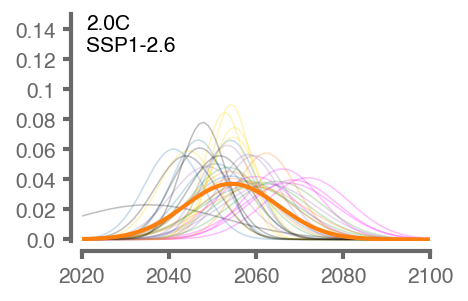

In [13]:
PLOT_YEAR = 2021
iyear = np.where(YEARS_UNIQUE==PLOT_YEAR)[0]
norm_incs = np.arange(-80,80,1)

plt.figure(figsize=(3,2))
norm_dist = tfp.distributions.Normal(pred_obs[-1,0],pred_obs[-1,1])
norm_cpd = norm_dist.prob(norm_incs)
plt.plot(norm_incs+PLOT_YEAR,
         norm_cpd,
         color='tab:orange',
         linewidth=2.,
         alpha=1.,
         zorder=50,
        )

for imodel in np.arange(0,N_GCMS):
    norm_cpd_mean = np.zeros(len(norm_incs))
    
    for ens in np.arange(0,mu_pred.shape[1]):
        norm_dist = tfp.distributions.Normal(mu_pred[imodel,ens,iyear],sigma_pred[imodel,ens,iyear])
        norm_cpd = norm_dist.prob(norm_incs)
        plt.plot(norm_incs+PLOT_YEAR,
                 norm_cpd,
                 color=clr[imodel],
                 linewidth=.75,
                 alpha=.25,
                )
    
plt.text(2021,
         .15,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )    

plt.xlim(2020,2100)
plt.yticks(np.arange(0,.25,.02),np.arange(0,.25,.02).round(2))
plt.ylim(-0.001,.15)
format_spines(plt.gca())
    

IndexError: index 7 is out of bounds for axis 1 with size 5

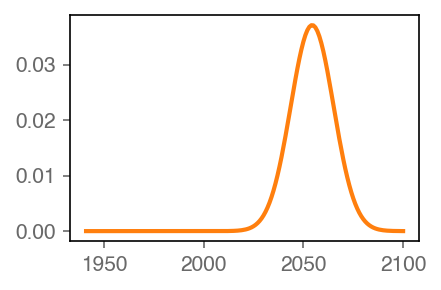

In [14]:
PLOT_YEAR = 2021
iyear = np.where(YEARS_UNIQUE==PLOT_YEAR)[0]
norm_incs = np.arange(-80,80,1)

plt.figure(figsize=(3,2))
norm_dist = tfp.distributions.Normal(pred_obs[-1,0],pred_obs[-1,1])
norm_cpd = norm_dist.prob(norm_incs)
plt.plot(norm_incs+PLOT_YEAR,
         norm_cpd,
         color='tab:orange',
         linewidth=2.,
         alpha=1.,
         zorder=100,
        )

for imodel in (0,1):
    ens = 7
    norm_dist = tfp.distributions.Normal(mu_pred[imodel,ens,iyear],sigma_pred[imodel,ens,iyear])
    norm_cpd = norm_dist.prob(norm_incs)
    plt.plot(norm_incs+PLOT_YEAR,
             norm_cpd,
             color=clr[imodel],
             linewidth=2.,
             alpha=1.,
             zorder=100,
            )
    
plt.text(2021,
         .15,
         str(settings["target_temp"]) + "C\nSSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="top",
         color='k', 
         # weight="bold",
        )    

plt.xlim(2020,2100)
plt.yticks(np.arange(0,.25,.05),np.arange(0,.25,.05).round(2))
plt.ylim(-0.001,.15)
format_spines(plt.gca())
    